# Translating Plate at 60°

In [11]:
using VortexModel

import VortexModel.Vortex
import Vortex.Sheets: arclength

## Set up plotting

The specifics of how we plot the figures are not important.  We will be using [`PyPlot`](https://github.com/JuliaPy/PyPlot.jl), but you can use any plotting package you like.

In [2]:
@static if isinteractive()
    using PyPlot
    function plot_system(sys)
        plate, (sheet₊, sheet₋) = sys
        plot(real.(plate.zs[[1,plate.N]]), imag.(plate.zs[[1,plate.N]]), "k")
        plot(real.(sheet₊.zs), imag.(sheet₊.zs), 
             linewidth = 1, color="#e41a1c")
        plot(real.(sheet₋.zs), imag.(sheet₋.zs), 
             linewidth = 1, color="#377eb8")
        axis(:scaled)
    end
    function plot_forces(T, pressures, impulse)
        w = Vortex.Plates.Chebyshev.clenshaw_curtis_weights(length(pressures[1]))
        Fₚ = map(pressures) do p
            -w[2:end-1] ⋅ p[2:end-1]
        end
        Fᵢ = abs.(gradient(impulse, step(T)))
        plot(T, Fₚ, linewidth = 2, color="#1f77b4")
        plot(T, Fᵢ, "--", linewidth = 2, color="#ff7f0e")
        xlabel("Time")
        ylabel("Normal Force")
        legend(("Integrated Pressure", "Rate of Change of Impulse"))
        axis([0, 9, 0, 6])
    end
else
    plot_system(sys) = nothing
    plot_forces(T, pressures, impulse) = nothing
end

plot_forces (generic function with 1 method)

## Initialize plate and sheets

We are simulating a flat plate with zero thickness impulsively translating horizontally:

In [5]:
L = 2.0   # chord length
f = 1.0   # frequency
Ax = 1.0L  # translational amplitude
Aα = π/4   # rotational amplitude
#ċparams = Vortex.Plates.Sinusoidal(2π*Ax*f,f,π/2,0.0)  # translation velocity
ċparams = Vortex.Plates.SteadyMotion(0.5L)  # translation velocity
#α̇params = Vortex.Plates.Sinusoidal(2π*Aα*f,f,0.0,π/2) # rotational velocity
α̇params = Vortex.Plates.SteadyMotion(0.0) # rotational velocity

α = π/3   # angle of attack

N = 128   # number of plate control points

#Δt = 1e-2/(2π*f); # time step
Δt = 1e-2

0.01

We discretize the shear layers as vortex sheets, and assume that the Kutta condition is enforced at both edges of the plate.

In [6]:
δ = 0.2
lesp = 0
tesp = 0

0

We place the initial segments of the vortex sheet perpendicular to the edges of the plate

In [12]:
plate = Vortex.Plate(N, L, zero(Complex128), α, ċparams, α̇params)
motion = Vortex.Plates.motion_function(plate,0.0)

Δz₀ = im*Δt*exp(im*α)
z₋, z₊ = plate.zs[[1,N]]

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, 1.0], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, 1.0], δ)

Vortex.Plates.enforce_no_flow_through!(plate, motion, ())
Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux(plate, sheet₊, sheet₋, lesp, tesp);

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, Γ₊], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, Γ₋], δ)

ambient_sys = (sheet₊, sheet₋)
sys = (plate, ambient_sys)
ẋs = [(motion, allocate_velocity(ambient_sys)) for k in 1:4];

# Storage used to compute forces later on
impulse = Complex128[]
pressures = Vector{Float64}[];
Γs₋ = Vortex.circulation(ambient_sys) .+ Vortex.Plates.bound_circulation(plate);

## Time Marching

At every time-step, before computing the self induced velocity of the system, we must first enforce the no-flow-through condition on the plate.  So the velocity function for time marching is:

In [8]:
function set_plate_motion!(v,motion)
    v = motion
end
function compute_ẋ!(ẋ, x, t)
    plate, ambient_sys = x
    motion = Vortex.Plates.motion_function(plate,t)
    
    Vortex.Plates.enforce_no_flow_through!(plate, motion, ambient_sys)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x)
    set_plate_motion!(ẋ[1],motion)
end

compute_ẋ! (generic function with 1 method)

The centers of new vortex sheet segments are placed a third of the distance between the edges of the plate to last segment of sheet:

In [9]:
function shed_new_vorticity!(sheet₊, sheet₋, plate, motion, lesp = 0.0, tesp = 0.0)
    z₊ = (sheet₊.blobs[end].z + 2plate.zs[end])/3
    z₋ = (sheet₋.blobs[end].z + 2plate.zs[1])/3
        
    segment₊ = Vortex.Blob.([sheet₊.blobs[end].z, z₊], [0.5, 0.5], δ)
    segment₋ = Vortex.Blob.([sheet₋.blobs[end].z, z₋], [0.5, 0.5], δ)
    Vortex.Plates.enforce_no_flow_through!(plate, motion, (sheet₊, sheet₋))
    
    Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux!(plate, segment₊, segment₋, lesp, tesp);
    Vortex.Sheets.append_segment!(sheet₊, z₊, Γ₊)
    Vortex.Sheets.append_segment!(sheet₋, z₋, Γ₋)
end

shed_new_vorticity! (generic function with 3 methods)

### Forward-Euler

We apply filtering on both the leading and trailing edge vortex sheets, and use the Kutta condition on both edges to determine the strength of new vortex segments:

In [ ]:
for t in 1.0:Δt:4.0
    push!(impulse, Vortex.impulse(sys))
    Δp, Γs₋ = Vortex.Plates.surface_pressure(sys[1], ẋs[4][1], sys[2][2], Γs₋, Δt)
    push!(pressures, Δp)
    rk4!(sys, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    arclength(sheet₊) ≥ 3Δt && Vortex.Sheets.filter!(sheet₊, 3Δt, 6Δt)
    arclength(sheet₋) ≥ 3Δt && Vortex.Sheets.filter!(sheet₋, 3Δt, 6Δt)
     
    shed_new_vorticity!(sheet₊, sheet₋, plate, ẋs[4][1], lesp, tesp)
end

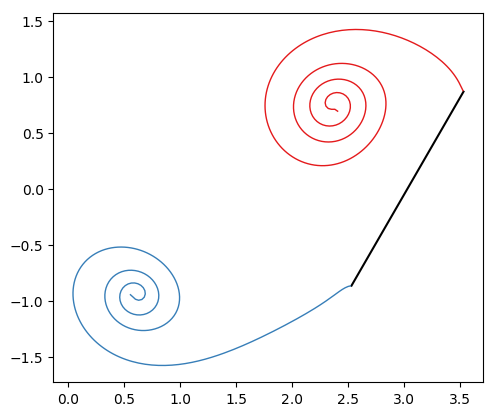

In [14]:
plot_system(sys);

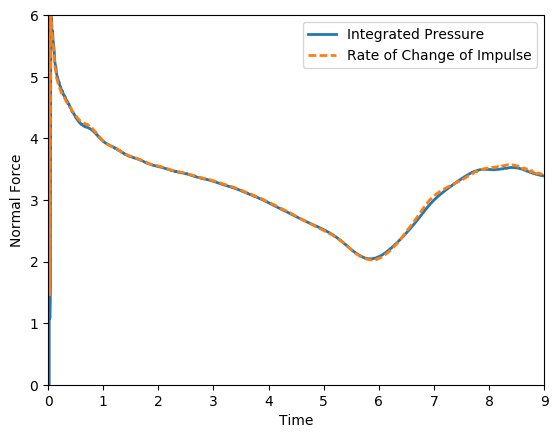

In [10]:
plot_forces(0.0:Δt:9.0, pressures, impulse);

In [194]:
lesp

0.4

In [119]:
plate

Plate: N = 128, L = 2.0, c = 1.6200000000000014 + 0.0im, α = 90.0ᵒ
       LESP = 0.1, TESP = 0.1